In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pickle

# 1. 데이터 불러오기 및 라벨링
df = pd.read_csv("merged_reviews.csv")
df = df.dropna(subset=["review", "score"])  # 결측 제거

def score_to_label(score):
    if score >= 8:
        return "positive"
    elif score <= 3:
        return "negative"
    else:
        return "neutral"

df["label"] = df["score"].apply(score_to_label)

# 2. 데이터 전처리
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

df["clean_review"] = df["review"].apply(clean_text)

# 너무 짧은 문장 제거
df = df[df["clean_review"].str.split().str.len() >= 3]

# 3. 토큰화 및 시퀀스 변환
MAX_LEN = 100
MAX_WORDS = 20000

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_review"])
X = tokenizer.texts_to_sequences(df["clean_review"])
X = pad_sequences(X, maxlen=MAX_LEN)

# 토크나이저 저장
with open("tokenizer_en.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# 4. 라벨 인코딩
label_map = {"negative": 0, "neutral": 1, "positive": 2}
y = df["label"].map(label_map).values

# 5. 훈련/검증 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 6. 모델 구성
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    Conv1D(128, 5, activation="relu"),
    GlobalMaxPooling1D(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

# 7. 학습
history = model.fit(X_train, y_train, epochs=5, batch_size=256, validation_data=(X_val, y_val))

# 8. 모델 저장
model.save("cnn_en_sentiment.h5")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          2560000   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                        

2538/2538 [==============================] - 4s 1ms/step


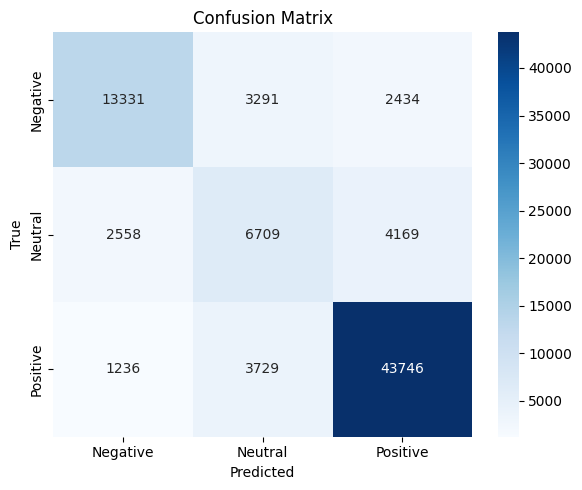

              precision  recall  f1-score    support
Negative          0.778   0.700     0.737  19056.000
Neutral           0.489   0.499     0.494  13436.000
Positive          0.869   0.898     0.883  48711.000
accuracy          0.786   0.786     0.786      0.786
macro avg         0.712   0.699     0.705  81203.000
weighted avg      0.785   0.786     0.784  81203.000


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. 예측 수행
y_pred_proba = model.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)

# 2. 혼동 행렬
labels = ["Negative", "Neutral", "Positive"]
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 3. Classification Report (F1, precision, recall 등)
report = classification_report(y_val, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).T
print(report_df.round(3))
